<a href="https://colab.research.google.com/github/apmoore1/NBADD/blob/master/AOC_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import defaultdict
import csv
from typing import List, Tuple, Dict

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [0]:
train_data_url = "https://github.com/UBC-NLP/aoc_id/raw/master/data/train/"\
                 "MultiTrain.Shuffled.csv"
val_data_url = "https://github.com/UBC-NLP/aoc_id/raw/master/data/dev/"\
               "MultiDev.csv"
test_data_url = "https://github.com/UBC-NLP/aoc_id/raw/master/data/test/"\
                "MultiTest.csv"

In [0]:
def get_data(csv_url: str) -> List[Tuple[str, str]]:
  '''
  Downloads the data from the given URL address and returns it as 
  a List of Tuples where each item in the List is a sample 
  containing [text, label].
  '''
  response = requests.get(csv_url)
  response.raise_for_status()
  assert response.encoding == 'utf-8', 'Should be UTF-8 encoding'
  
  csv_lines = response.text.split('\n')
  csv_reader = csv.reader(csv_lines)
  
  data: List[Tuple[str, str]] = []
  for line_index, csv_line in enumerate(csv_reader):
    if line_index == 0 or not csv_line:
      continue
    assert len(csv_line) == 3, f'{csv_line} {line_index}'
    data_index, label, text = csv_line
    data.append((text, label))
  return data

def class_breakdown(aoc_data: List[Tuple[str, str]],
                    expected_num_classes: int = 4) -> Dict[str, int]:
  '''
  Returns the number of samples per class given AOC data
  '''
  label_count = defaultdict(lambda: 0)
  for text, label in aoc_data:
    label_count[label] += 1
  label_error = (f'Number of labels found {label_count.keys()} more'
                 f' than expected {expected_num_classes}')
  assert len(label_count) == expected_num_classes, label_error
  return label_count

def pandas_class_breakdown(aoc_data: List[Tuple[str, str]]) -> pd.Series:
  '''
  Returns the number of samples per class given AOC Data as a pandas Series 
  where the Series index is the class label
  '''
  label_count = defaultdict(lambda: 0)
  for text, label in aoc_data:
    label_count[label] += 1
  return pd.Series(label_count)

def samples_per_class(aoc_data: List[Tuple[str, str]], 
                      class_order: List[str]) -> List[int]:
  '''
  Returns the number of samples in each class that is specified in 
  the class_order.
  '''
  num_per_class = class_breakdown(aoc_data)
  return [num_per_class[_class] for _class in class_order]

def check_same_classes(*datasets) -> bool:
  '''
  Given a list of AOC datasets check that all of them have the same 
  class labels
  '''
  classes = set()
  for index, dataset in enumerate(datasets):
    dataset_classes = list(class_breakdown(dataset).keys())
    dataset_classes = set(dataset_classes)
    if index == 0:
      classes = set(dataset_classes)
    else:
      if classes != dataset_classes:
        return False
  return True
      
def remove_no_text_samples(aoc_data: List[Tuple[str, str]]
                           ) -> List[Tuple[str, str]]:
  '''
  Returns the same list of data given but without samples that have no text.
  '''
  processed_data = []
  for text, label in aoc_data:
    if text.strip():
      processed_data.append((text, label))
  return processed_data
    
def plot_label_dist(train_data: List[Tuple[str, str]], 
                    val_data: List[Tuple[str, str]], 
                    test_data: List[Tuple[str, str]]) -> None:
  '''
  Given the train, validation, and test datasets from the AOC data it creates 
  two stacked bar chart showing the label distribution for each of the datasets.
  
  The first bar chart shows the raw sample distribution for the labels and the 
  second the normalised distribution with respect to each dataset.
  '''
  length_datasets = np.array([len(train_data), len(val_data), len(test_data)])
  normalizer = lambda x: x / length_datasets

  train_samples_per_class = samples_per_class(train_data, aoc_classes)
  val_samples_per_class = samples_per_class(val_data, aoc_classes)
  test_samples_per_class = samples_per_class(test_data, aoc_classes)
  dataset_samples_per_class = [train_samples_per_class, val_samples_per_class,
                               test_samples_per_class]

  egyptian_samples = np.array([dataset[0] 
                               for dataset in dataset_samples_per_class])
  msa_samples = np.array([dataset[3] 
                          for dataset in dataset_samples_per_class]) 
  gulf_samples = np.array([dataset[1] 
                           for dataset in dataset_samples_per_class])
  levantine_samples = np.array([dataset[2] 
                                for dataset in dataset_samples_per_class])
  
  samples = [egyptian_samples, msa_samples, gulf_samples, levantine_samples]
  norm_samples = [normalizer(dataset_samples) for dataset_samples in samples]
  all_samples = [samples, norm_samples]
  
  width = 0.35
  ind = [0, 1, 2]
  bar_containers = []
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  for ax_index, ax in enumerate(axs):
    dataset_samples = all_samples[ax_index]
    for sample_index, samples in enumerate(dataset_samples):
      bar_container = ax.bar(ind, samples, width, 
                             bottom=sum(dataset_samples[0:sample_index]))
      bar_containers.append(bar_container[0])

    if ax_index == 1:
      ax.set_ylabel('Normalised number of samples')
      ax.set_title('Normalised Label Distribution Across the Datasets')
    else:
      ax.set_ylabel('Number of samples')
      ax.set_title('Label Distribution Across the Datasets')
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Train', 'Validation', 'Test'])
    if ax_index == 0:
      ax.legend(bar_containers, ['Egyptian', 'MSA', 'Gulf', 'Levantine'])
  
def altair_aoc_data(aoc_datasets) -> pd.DataFrame:
  dataset_names = []
  labels = []
  counts = []
  for dataset_name, dataset in aoc_datasets.items():
    label_count = defaultdict(lambda: 0)
    for text, label in dataset:
      label_count[label] += 1
    for label, count in label_count.items():
      labels.append(label)
      counts.append(count)
      dataset_names.append(dataset_name)
  return pd.DataFrame({'Dataset': dataset_names, 'Label': labels, 
                       'Sample Count': counts})

def alt_norm_break(aoc_data: pd.DataFrame) -> pd.DataFrame:
  total_per_dataset_counts = aoc_data.groupby(['Dataset'])['Sample Count'].sum()
  aoc_data = aoc_data.set_index(['Dataset', 'Label'])
  sample_counts = pd.Series(aoc_data['Sample Count'].values, 
                            index=aoc_data.index)
  norm_sample_counts = sample_counts / total_per_dataset_counts
  norm_sample_counts.index = aoc_data.index
  aoc_data['Sample Count'] = norm_sample_counts
  aoc_data = aoc_data.reset_index()
  return aoc_data
  

def create_label_chart(aoc_data: pd.DataFrame):
  return alt.Chart(aoc_data).mark_bar().encode(
    alt.X('Dataset', sort=['Train', 'Val', 'Test']),
    y='Sample Count',
    color='Label',
    tooltip=['Sample Count', 'Label']
  ).interactive()

# [Arabic Online Commentary (AOC)](https://aclanthology.coli.uni-saarland.de/papers/P11-2007/p11-2007) dataset distribution.

This notebook will show the distribution of the AOC dataset used in the following [paper](https://aclanthology.coli.uni-saarland.de/papers/W18-3930/w18-3930). We will then show the distribution of the dataset after pre-processing by removing samples that contain no Text but does have an associated label. This final pre-prcoessed dataset will then be used in all of our subsequent experiments.

## Distribution of the AOC dataset

In [0]:
train_data = get_data(train_data_url)
val_data = get_data(val_data_url)
test_data = get_data(test_data_url)
# Ensure all the data have the same class names
assert check_same_classes(train_data, val_data, test_data)
# Classes in the dataset
aoc_classes = list(class_breakdown(test_data).keys())
aoc_classes

['DIAL_EGY', 'DIAL_GLF', 'DIAL_LEV', 'MSA']

In [0]:
data_breakdown = altair_aoc_data({'Train': train_data, 'Val': val_data, 
                                  'Test': test_data})
norm_data_breakdown = alt_norm_break(data_breakdown)

title = 'Label Distribution Across the Datasets'
label_chart = create_label_chart(data_breakdown)\
              .properties(height=300, width=200, title=title)

norm_title = 'Normalised Label Distribution Across the Datasets'
norm_label_chart = create_label_chart(norm_data_breakdown)\
                   .properties(height=300, width=200, title=norm_title)
label_chart | norm_label_chart

HConcatChart({
  hconcat: [Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA         50845
    1    Train  DIAL_LEV          9081
    2    Train  DIAL_GLF         16593
    3    Train  DIAL_EGY         10022
    4      Val  DIAL_EGY          1253
    5      Val  DIAL_GLF          2075
    6      Val  DIAL_LEV          1136
    7      Val       MSA          6356
    8     Test  DIAL_EGY          1252
    9     Test  DIAL_GLF          2073
    10    Test  DIAL_LEV          1133
    11    Test       MSA          6354,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector001: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Label Distribution Across the Datasets',
    width: 200
  }), Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA      0.587525
    1    Train  DIAL_LEV      0.104933
    2    Train  DIAL_GLF      0.191736
    3    Train  DIAL_EGY      0.115806
    4      Val  DIAL_EGY      0.115804
    5      Val  DIAL_GLF      0.191774
    6      Val  DIAL_LEV      0.104991
    7      Val       MSA      0.587431
    8     Test  DIAL_EGY      0.115797
    9     Test  DIAL_GLF      0.191731
    10    Test  DIAL_LEV      0.104791
    11    Test       MSA      0.587680,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector002: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Normalised Label Distribution Across the Datasets',
    width: 200
  })]
})

Above is an interactive chart where if you hover over the bars it will display the sample count for each label distribution for each dataset. Below is a static graph with no interaction. These were made to compare the matplotlib and the altair libraries.

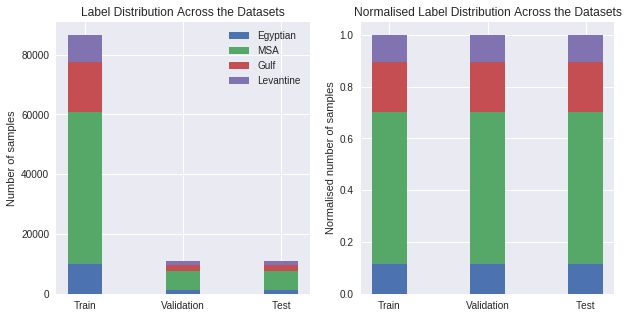

In [0]:
plot_label_dist(train_data, val_data, test_data)

In [0]:
train_breakdown = pandas_class_breakdown(train_data)
val_breakdown = pandas_class_breakdown(val_data)
test_breakdown = pandas_class_breakdown(test_data)
dataset_breakdowns = pd.concat((train_breakdown, val_breakdown, test_breakdown), 
                               1, keys=['Train', 'Val', 'Test'])
total = pd.Series(dataset_breakdowns.sum(), name='Total')
total_dataset_breakdowns = dataset_breakdowns.T.join(total).T
total_dataset_breakdowns

,Train,Val,Test
DIAL_EGY,10022,1253,1252
DIAL_GLF,16593,2075,2073
DIAL_LEV,9081,1136,1133
MSA,50845,6356,6354
Total,86541,10820,10812


As we can see the vast majority of the dataset is made up of the MSA dialect then followed by Gulf, Egyptian, and Levantine. Now we shall see how this is affected when samples are removed due to not having any text within the sample and thus should not be within the dataset.

## Removal of Non-Text samples

In [0]:
pro_train_data = remove_no_text_samples(train_data)
pro_val_data = remove_no_text_samples(val_data)
pro_test_data = remove_no_text_samples(test_data)
# Ensure all the data have the same class names
assert check_same_classes(pro_train_data, pro_test_data, pro_test_data)

In [0]:
pro_data_breakdown = altair_aoc_data({'Train': pro_train_data, 
                                      'Val': pro_val_data, 
                                      'Test': pro_test_data})
pro_norm_data_breakdown = alt_norm_break(pro_data_breakdown)

pro_label_chart = create_label_chart(pro_data_breakdown)\
                  .properties(height=300, width=200, 
                              title='Processed ' + title)

pro_norm_label_chart = create_label_chart(pro_norm_data_breakdown)\
                       .properties(height=300, width=200, 
                                   title= 'Processed ' + norm_title)
pro_label_chart | pro_norm_label_chart

HConcatChart({
  hconcat: [Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA         50153
    1    Train  DIAL_LEV          9041
    2    Train  DIAL_GLF         16494
    3    Train  DIAL_EGY          9970
    4      Val  DIAL_EGY          1252
    5      Val  DIAL_GLF          2069
    6      Val  DIAL_LEV          1130
    7      Val       MSA          6229
    8     Test  DIAL_EGY          1243
    9     Test  DIAL_GLF          2066
    10    Test  DIAL_LEV          1126
    11    Test       MSA          6269,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector003: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Processed Label Distribution Across the Datasets',
    width: 200
  }), Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA      0.585503
    1    Train  DIAL_LEV      0.105548
    2    Train  DIAL_GLF      0.192556
    3    Train  DIAL_EGY      0.116393
    4      Val  DIAL_EGY      0.117228
    5      Val  DIAL_GLF      0.193727
    6      Val  DIAL_LEV      0.105805
    7      Val       MSA      0.583240
    8     Test  DIAL_EGY      0.116125
    9     Test  DIAL_GLF      0.193012
    10    Test  DIAL_LEV      0.105194
    11    Test       MSA      0.585669,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector004: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Processed Normalised Label Distribution Across the Datasets',
    width: 200
  })]
})

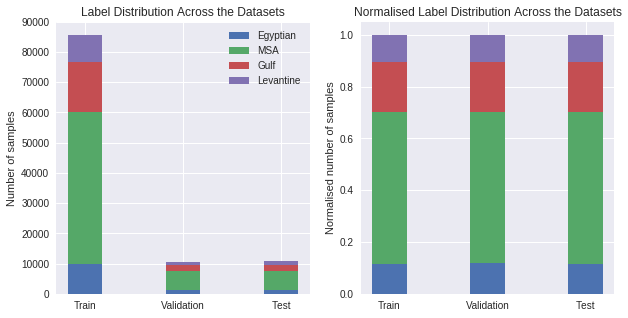

In [0]:
plot_label_dist(pro_train_data, pro_val_data, pro_test_data)

In [0]:
pro_train_breakdown = pandas_class_breakdown(pro_train_data)
pro_val_breakdown = pandas_class_breakdown(pro_val_data)
pro_test_breakdown = pandas_class_breakdown(pro_test_data)
pro_breakdowns = (pro_train_breakdown, pro_val_breakdown, pro_test_breakdown)
pro_dataset_breakdowns = pd.concat(pro_breakdowns, 1, 
                                   keys=['Train', 'Val', 'Test'])
total = pd.Series(pro_dataset_breakdowns.sum(), name='Total')
pro_total_dataset_breakdowns = pro_dataset_breakdowns.T.join(total).T
pro_total_dataset_breakdowns

,Train,Val,Test
DIAL_EGY,9970,1252,1243
DIAL_GLF,16494,2069,2066
DIAL_LEV,9041,1130,1126
MSA,50153,6229,6269
Total,85658,10680,10704


From the above we cannot see much difference between the removed and the original, however below we show the difference from the original and the removed. From the table below we can see that the class that is affected the most is the MSA class which is expected as this is the majority class. However only around 1% of the data is affected, but this new removed dataset is the dataset that we shall use for all of our experiments.

In Two cells below we can see easier how the different label distribution are affected by this pre-processing step. Even though MSA is the largest class and is expected to be affected by this the most compared to the normal distribution of the MSA class in the datasets it is affected more than expected, espically in the validation set.

In [0]:
total_dataset_breakdowns - pro_total_dataset_breakdowns

,Train,Val,Test
DIAL_EGY,52,1,9
DIAL_GLF,99,6,7
DIAL_LEV,40,6,7
MSA,692,127,85
Total,883,140,108


In [0]:
diff_breakdown = data_breakdown.copy()
diff_breakdown['Sample Count'] = (data_breakdown['Sample Count'] - 
                                  pro_data_breakdown['Sample Count'])
diff_breakdown
norm_diff_breakdown = alt_norm_break(diff_breakdown)

diff_title = 'Difference in Label Distribution between Non and Processed'
diff_label_chart = create_label_chart(diff_breakdown)\
                  .properties(height=300, width=200, title=diff_title)

norm_diff_label_chart = create_label_chart(norm_diff_breakdown)\
                       .properties(height=300, width=200, 
                                   title='Normalised ' + diff_title)
diff_label_chart | norm_diff_label_chart

HConcatChart({
  hconcat: [Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA           692
    1    Train  DIAL_LEV            40
    2    Train  DIAL_GLF            99
    3    Train  DIAL_EGY            52
    4      Val  DIAL_EGY             1
    5      Val  DIAL_GLF             6
    6      Val  DIAL_LEV             6
    7      Val       MSA           127
    8     Test  DIAL_EGY             9
    9     Test  DIAL_GLF             7
    10    Test  DIAL_LEV             7
    11    Test       MSA            85,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector005: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Difference in Label Distribution between Non and Processed',
    width: 200
  }), Chart({
    data:    Dataset     Label  Sample Count
    0    Train       MSA      0.783692
    1    Train  DIAL_LEV      0.045300
    2    Train  DIAL_GLF      0.112118
    3    Train  DIAL_EGY      0.058890
    4      Val  DIAL_EGY      0.007143
    5      Val  DIAL_GLF      0.042857
    6      Val  DIAL_LEV      0.042857
    7      Val       MSA      0.907143
    8     Test  DIAL_EGY      0.083333
    9     Test  DIAL_GLF      0.064815
    10    Test  DIAL_LEV      0.064815
    11    Test       MSA      0.787037,
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: 'Label'
      }),
      tooltip: [Tooltip({
        shorthand: 'Sample Count'
      }), Tooltip({
        shorthand: 'Label'
      })],
      x: X({
        shorthand: 'Dataset',
        sort: ['Train', 'Val', 'Test']
      }),
      y: Y({
        shorthand: 'Sample Count'
      })
    }),
    height: 300,
    mark: 'bar',
    selection: SelectionMapping({
      selector006: SelectionDef({
        bind: 'scales',
        encodings: ['x', 'y'],
        type: 'interval'
      })
    }),
    title: 'Normalised Difference in Label Distribution between Non and Processed',
    width: 200
  })]
})